# Синтез изображений. Часть 1. Вариационный Автоэнкодер (VAE)

## Переключение версии TensorFlow

In [1]:
%tensorflow_version 2.x

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf

## Загрузка и подготовка датасета MNIST

In [3]:
(train_x, train_y), (test_x, test_y) = tf.keras.datasets.mnist.load_data()

train_x = train_x.reshape(-1, 28, 28, 1).astype(np.float32) / 255.
test_x = test_x.reshape(-1, 28, 28, 1).astype(np.float32) / 255.

11501568/11490434 [==============================] - 0s 0us/step


## Визуализация датасета MNIST

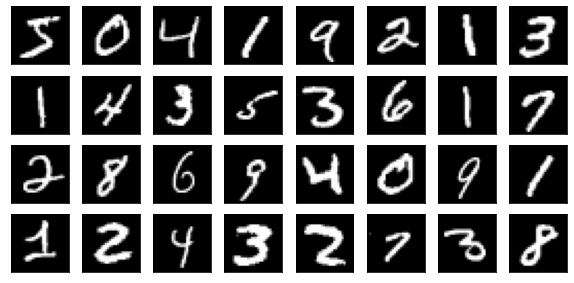

In [4]:
def plot_digits(samples):
    fig = plt.figure(figsize=(10, 10))
    for j in range(samples.shape[0]):
        ax = fig.add_subplot(8, 8, j+1)
        ax.imshow(samples[j,:,:,0], cmap='gray')
        plt.xticks([]), plt.yticks([])
    plt.show()

plot_digits(train_x[:32, ...])

## Создание Энкодера и Декодера

In [6]:
class Encoder(tf.keras.Model):
    
    def __init__(self):
        super().__init__()

        self.conv1 = tf.keras.layers.Conv2D(32, (5, 5), padding='same', activation='relu')
        self.conv2 = tf.keras.layers.Conv2D(64, (5, 5), padding='same', activation='relu')
        self.fc1 = tf.keras.layers.Dense(256, activation='relu')
        self.fc_mean = tf.keras.layers.Dense(2, activation=None)
        self.fc_log_sigma = tf.keras.layers.Dense(2, activation=None)
        self.max_pool = tf.keras.layers.MaxPool2D((2, 2), (2, 2))
        self.flatten = tf.keras.layers.Flatten()
        
    def call(self, inp):
        # извлекаем признаки и пониэаем размерность
        out = self.conv1(inp)
        out = self.max_pool(out)
        out = self.conv2(out)
        out = self.max_pool(out)
        out = self.flatten(out)
        # получаем какие-то признаки с помозь полносвязного слоя
        # это и есть наш промежуточный скрытый вектор
        out = self.fc1(out)
        
        # Энкодер предсказывает параметры нормального вероятностного распределения
        # Его параметры это мат ожидание и СКО
        # Вектор мат ожиданий
        z_mean = self.fc_mean(out)
        # Вектор логарифмов СКО, т.к. out может вернуть значения от -inf +inf
        z_log_sigma = self.fc_log_sigma(out)
        
        # Генерируем вектор из нормального распределения
        # Он необходим для генерации случайного вектора
        rnd = tf.random.normal(tf.shape(z_mean))
        # tf.exp(z_log_sigma) - экспонента чтобы получить настоящее СКО
        # Генерируем z(случайный вектор) с мат ожиданием z_mean и СКО tf.exp(z_log_sigma)
        z = z_mean + tf.exp(z_log_sigma) * rnd
        return z_mean, z_log_sigma, z

class Decoder(tf.keras.Model):

    def __init__(self):
        super().__init__()

        self.fc1 = tf.keras.layers.Dense(7*7*64, activation='relu')
        self.conv1 = tf.keras.layers.Conv2D(64, (5, 5), padding='valid', activation='relu')
        self.conv2 = tf.keras.layers.Conv2D(32, (5, 5), padding='valid', activation='relu')
        self.conv3 = tf.keras.layers.Conv2D(1, (5, 5), padding='valid', activation='sigmoid')
        self.upsample = tf.keras.layers.UpSampling2D((2, 2))

    def call(self, inp):
        batch_size = inp.shape[0]
        # 1. Применяем какое-то линейное преобразование, чтобы повысить размерность и сделать более разнообразным
        out = self.fc1(inp)
        # 2. Из батча веторов делаем батч 3х мерных тензоров размера (7, 7, 64)
        # получаем многомерный тензор размерности (batch_size, 7, 7, 64)
        out = tf.reshape(out, (batch_size, 7, 7, 64))
        # Простой upsampling keras х2, который делает интерполяцию ближайшего соседа
        # на вход подается картинка 7х7, на выходе этого слоя картинка будет 14х14
        out = self.upsample(out)
        # Сверточный слой использует padding='valid', чтобы не было проблемы с zero padding(избежать артефакты на границах изображения)\
        # Иными словами наше ядро свертки не выступает за пределы изображения
        out = self.conv1(out)
        # на выходе имеем размерность (14,14) - (5,5) = (10,10)
        out = self.upsample(out)
        # (20, 20)
        out = self.conv2(out)
        # (16, 16)
        out = self.upsample(out)
        # (32, 32)
        out = self.conv3(out)
        # (28, 28) и один канал + activation='sigmoid' - выходные значения в диапазоне [0,1]
        return out

encoder = Encoder()
decoder = Decoder()

## Инференс и функция потерь для VAE

Физ смысл KL_loss(KL дивергенции):

tmp = 1 + z_log_sigma - tf.square(z_mean) - tf.exp(z_log_sigma)

Нам нужно наше вероятностное распределение притягивать к нормальному (0, 1):
- Если мат оижадение модели будет 0, то tf.square(z_mean) зануляется
- Если tf.exp(z_log_sigma) будет 1, то 1 - tf.exp(z_log_sigma) будет 0
- Логаримф сигмы (z_log_sigma) тоже будет = 0 (log1 = 0)

In [8]:
# Прямое распространение автоэнкодера
# Получение картинки(батчей из кортинок)
def vae(inp):
    _, _, z = encoder(inp)
    out = decoder(z)
    return out

def vae_loss(inp, target):
        z_mean, z_log_sigma, z = encoder(inp)
        pred = decoder(z)
        
        # Reconstruction loss
        # вычисляем MSE и делаем reduce_sum по картиночным измерениям (высота, ширина, каналы)
        # получаем батч из лоссов
        mse_loss = tf.reduce_sum(tf.square(pred - target), axis=[1, 2, 3])
        # притягиваем наше вероятностное распределение(z_mean, z_log_sigma) к нормальному
        tmp = 1 + z_log_sigma - tf.square(z_mean) - tf.exp(z_log_sigma)
        # KL - расстояние между двумя вероятностными распределениями
        # делаем reduce_mean по последнему измерению
        KL_loss = -0.5 * tf.reduce_sum(tmp, axis=-1)
        # усредняем по всему батчу и получаем единый скаляр лосса
        return tf.reduce_mean(mse_loss + KL_loss)

## Подготовка пайплайна данных и оптимизатора

In [10]:
NUM_EPOCHS = 25
BATCH_SIZE = 128
LEARNING_RATE = 0.001

train_ds = tf.data.Dataset.from_tensor_slices(train_x)
train_ds = train_ds.shuffle(buffer_size=train_x.shape[0])
train_ds = train_ds.batch(BATCH_SIZE, drop_remainder=True)

# оптимизатор RMSprop
optimizer = tf.keras.optimizers.RMSprop(LEARNING_RATE)

## Обучение VAE

[Epoch  0] Train Loss: 41.6113


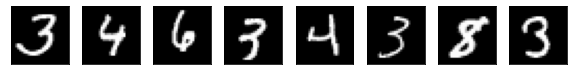

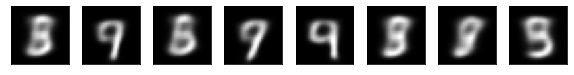

[Epoch  1] Train Loss: 36.7810


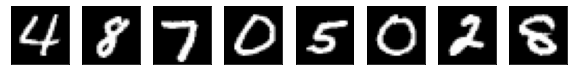

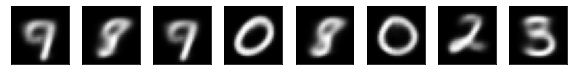

[Epoch  2] Train Loss: 32.9460


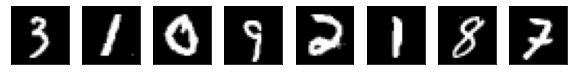

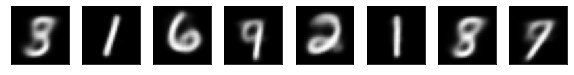

[Epoch  3] Train Loss: 34.0297


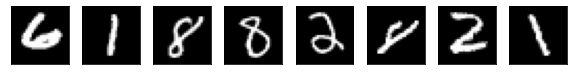

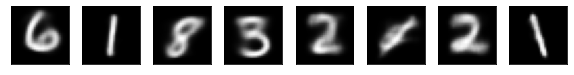

[Epoch  4] Train Loss: 34.9798


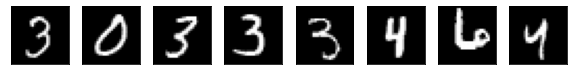

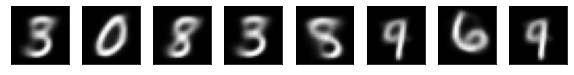

[Epoch  5] Train Loss: 35.0296


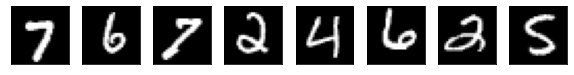

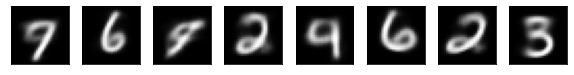

[Epoch  6] Train Loss: 32.2518


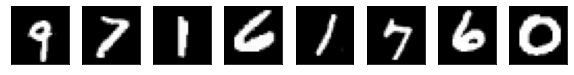

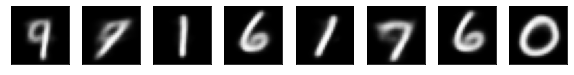

[Epoch  7] Train Loss: 32.5286


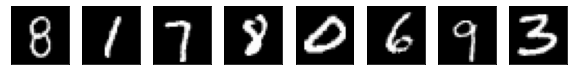

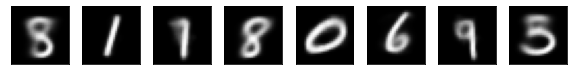

[Epoch  8] Train Loss: 31.0725


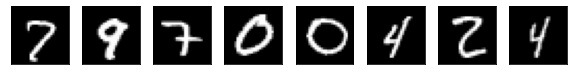

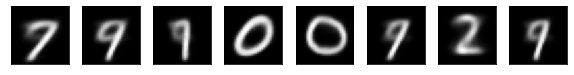

[Epoch  9] Train Loss: 31.5766


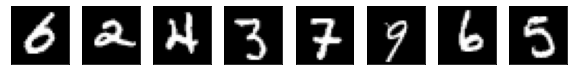

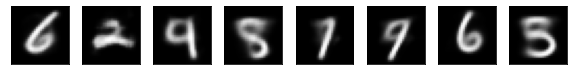

[Epoch 10] Train Loss: 30.3580


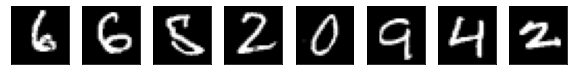

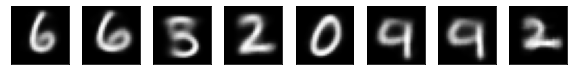

[Epoch 11] Train Loss: 32.5539


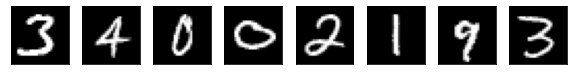

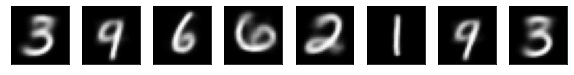

[Epoch 12] Train Loss: 33.4260


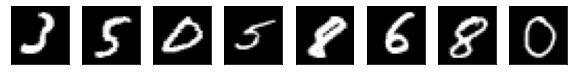

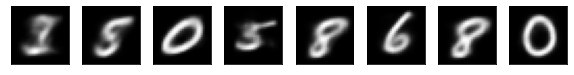

[Epoch 13] Train Loss: 32.6817


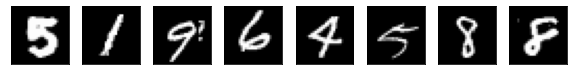

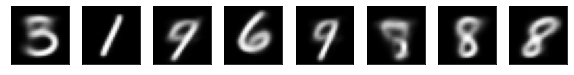

[Epoch 14] Train Loss: 32.7673


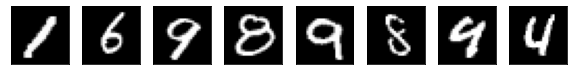

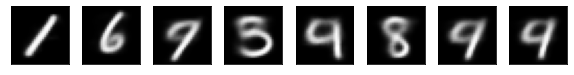

[Epoch 15] Train Loss: 34.2913


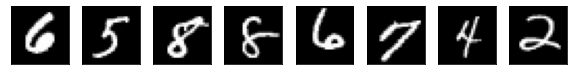

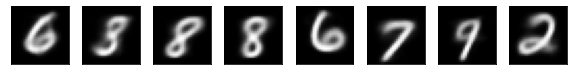

[Epoch 16] Train Loss: 30.5999


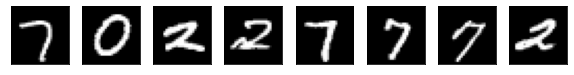

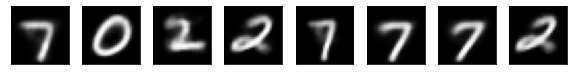

[Epoch 17] Train Loss: 32.4138


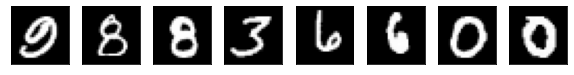

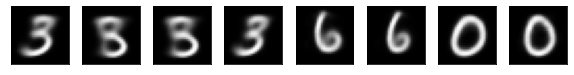

[Epoch 18] Train Loss: 31.0996


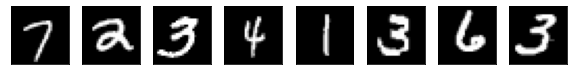

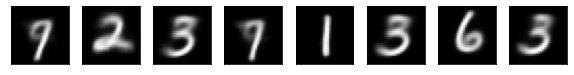

[Epoch 19] Train Loss: 31.6487


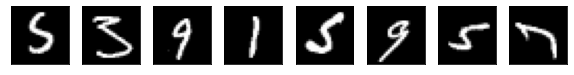

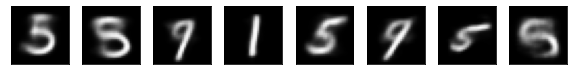

[Epoch 20] Train Loss: 30.8770


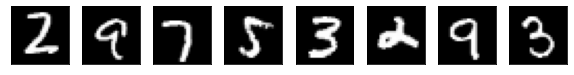

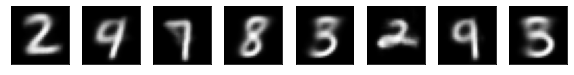

[Epoch 21] Train Loss: 33.4040


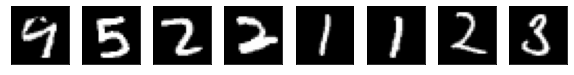

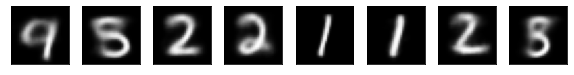

[Epoch 22] Train Loss: 30.4059


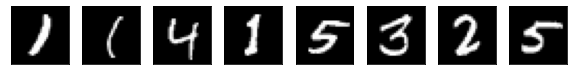

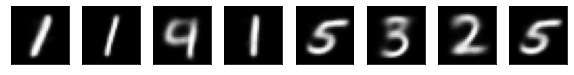

[Epoch 23] Train Loss: 32.7871


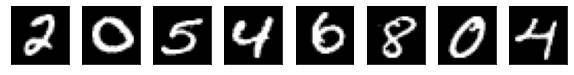

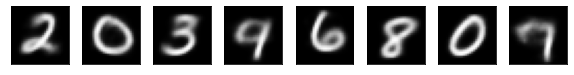

[Epoch 24] Train Loss: 33.2648


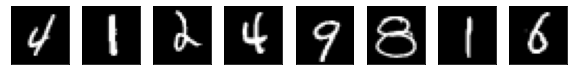

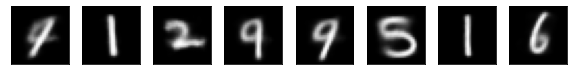

In [12]:
for e in range(NUM_EPOCHS):
    for batch in train_ds:   
        with tf.GradientTape() as tape:
          # прямое распространиение - получаем лосс
          # у нас на входе батч наших картинок и желаемое целевое значение - тот же самый батч
            loss_value = vae_loss(batch, batch)
        # сумма параметров энкодера и декодера - общий список всех параметров
        train_vars = encoder.variables + decoder.variables
        # вычисляем градиент по всем параметрам
        grads = tape.gradient(loss_value, train_vars)
        # оптимизируем градиент, где train_vars - параметры, к которым мы применяем эти градиенты
        optimizer.apply_gradients(zip(grads, train_vars))

    print("[Epoch %2d] Train Loss: %.4f" % (e, loss_value.numpy()))

    batch_pred = vae(batch[0:8])
    plot_digits(batch[0:8])
    plot_digits(batch_pred)

## Применение VAE на тестовых образцах

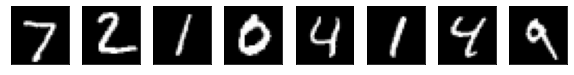

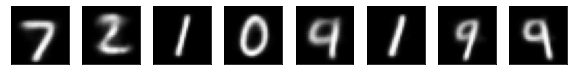

In [13]:
text_x_pred = vae(test_x[0:8])

plot_digits(test_x[0:8])
plot_digits(text_x_pred)

## VAE в режиме синтеза. Интерполяция в латентном пространстве

Фишка вариационного автоэнкодера в том, что теперь мы можем использовать декодер как генератор по случайному вектору из нормального распределения, как мы делал с случайным вектором z

Возьмем некоторую сетку с помощью двумерного цикла и для каждой точки попробуем сгенерировать картинки

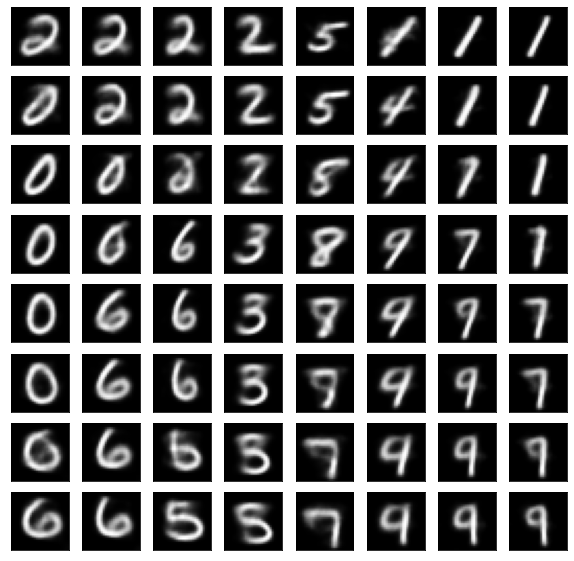

In [14]:
generated_list = []

for xi in np.linspace(-1, 1, 8):
    for xj in np.linspace(-1, 1, 8):
        generated = decoder(np.array([[xi, xj]]).astype(np.float32))
        generated_list.append(generated)

plot_digits(np.concatenate(generated_list))

Мы взяли точки в латентном пространсве(нормального распределения) и сгенерировали по этим точкам изображения, которых не было в датасете MNIST. Сеть была обучена только на цифрах, поэтому и генерирует она только цифры